<a href="https://colab.research.google.com/github/Fremiud/Proyect2-AI/blob/main/Regression_AI_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Load and preprocess the dataset

In [182]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names, na_values="?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.dropna()

# # One-hot encoding for the 'Origin' column
# origin = dataset.pop('Origin')
# dataset['USA'] = (origin == 1) * 1.0
# dataset['Europe'] = (origin == 2) * 1.0
# dataset['Japan'] = (origin == 3) * 1.0

# Associate each Origin ID with a specific country
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
# Associate each Origin ID now with a one hot vector
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

# Split the dataset (replace train_test_split)
train_dataset = dataset.sample(frac=0.8, random_state=42)

test_dataset = dataset.drop(train_dataset.index)

train_features = torch.tensor(train_dataset.drop('MPG', axis=1).values, dtype=torch.float32)
train_labels = torch.tensor(train_dataset['MPG'].values, dtype=torch.float32).view(-1, 1)

test_features = torch.tensor(test_dataset.drop('MPG', axis=1).values, dtype=torch.float32)
test_labels = torch.tensor(test_dataset['MPG'].values, dtype=torch.float32).view(-1, 1)

# Normalize the dataset using torch.nn.functional.normalize()
train_features = F.normalize(train_features, dim=0)
test_features = F.normalize(test_features, dim=0)

# Create DataLoader for training data
batch_size = 32
train_dataset = TensorDataset(train_features, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


<ipython-input-182-7647582f049e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


# Step 2: Define the neural network models


In [183]:
class Network1(nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.fc = nn.Linear(9, 1)

    def forward(self, x):
        return self.fc(x)

class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.fc1 = nn.Linear(9, 10, bias=True)
        self.fc2 = nn.Linear(10, 20,bias=True)
        self.fc3 = nn.Linear(20, 10,bias=True)
        self.fc4 = nn.Linear(10, 1,bias=True)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

class Network3(nn.Module):
    def __init__(self):
        super(Network3, self).__init__()
        self.fc1 = nn.Linear(9, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 30)
        self.fc4 = nn.Linear(30, 20)
        self.fc5 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return  self.fc5(x)


# Step 3: Train and evaluate the models


### Defining the train and evalute function


In [184]:
def train_model(model, epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    
    train_losses = []
    test_losses = []

    # Print table header
    print(f'{"Epoch":<6}{"Train Loss":<12}{"Test Loss":<12}')
    print("-" * 30)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        num_batches = 0

        for batch_features, batch_labels in train_dataloader:
            optimizer.zero_grad()
            predictions = model.forward(batch_features)

            loss = criterion(predictions, batch_labels)
            running_loss += loss.item()
            num_batches += 1

            loss.backward()
            optimizer.step()
        
        avg_train_loss = running_loss / num_batches
        train_losses.append(avg_train_loss)

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            test_predictions = model(test_features)
            test_loss = criterion(test_predictions, test_labels)
            test_losses.append(test_loss.item())

        if (epoch + 1) % 5 == 0:
            # Print losses in tabular format
            print(f'{epoch + 1:<6}{avg_train_loss:<12.4f}{test_loss.item():<12.4f}')
    
    return train_losses, test_losses

### Train and evaluate each network


In [185]:
# [Optional] Set the random seed for PyTorch and NumPy
# torch.manual_seed(5649665367228949740)

epochs = 20
learning_rate = 0.01

print("Network #1")
model1 = Network1()
train_losses1, test_losses1= train_model(model1, epochs, learning_rate)

print("\nNetwork #2")
model2 = Network2()
train_losses2, test_losses2 = train_model(model2, epochs, learning_rate)

print("\nNetwork #3")
model3 = Network3()
train_losses3, test_losses3 = train_model(model3, epochs, learning_rate)


Network #1
Epoch Train Loss  Test Loss   
------------------------------
5     149.1900    146.1333    
10    73.2739     73.5495     
15    63.7509     61.2782     
20    62.0479     58.6719     

Network #2
Epoch Train Loss  Test Loss   
------------------------------
5     65.1193     56.5187     
10    62.9604     69.1193     
15    66.2912     56.1092     
20    66.2879     58.3905     

Network #3
Epoch Train Loss  Test Loss   
------------------------------
5     182.9897    182.2705    
10    77.1513     80.9428     
15    63.7909     63.3642     
20    61.7762     59.3880     


#Step 4: Present Loss Graphs

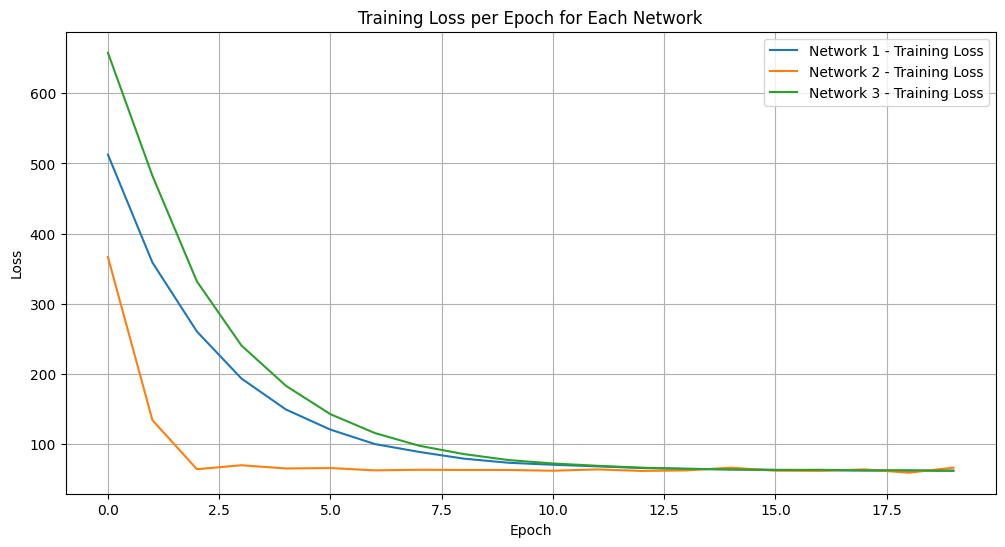

In [186]:
#@title Training Loss Graph Result
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training losses
plt.plot(train_losses1, label='Network 1 - Training Loss')
plt.plot(train_losses2, label='Network 2 - Training Loss')
plt.plot(train_losses3, label='Network 3 - Training Loss')

# Plot test losses
# plt.plot(test_losses1, linestyle='--', label='Network 1 - Test Loss')
# plt.plot(test_losses2, linestyle='--', label='Network 2 - Test Loss')
# plt.plot(test_losses3, linestyle='--', label='Network 3 - Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss per Epoch for Each Network')
plt.grid(True)
plt.show()


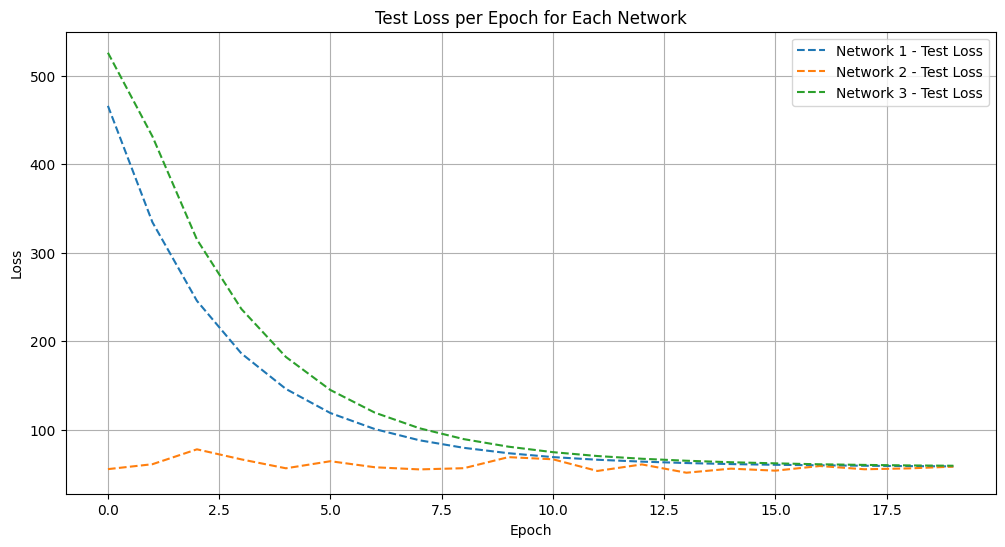

In [187]:
#@title Test Loss Graph Result
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot test losses
plt.plot(test_losses1, linestyle='--', label='Network 1 - Test Loss')
plt.plot(test_losses2, linestyle='--', label='Network 2 - Test Loss')
plt.plot(test_losses3, linestyle='--', label='Network 3 - Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Test Loss per Epoch for Each Network')
plt.grid(True)
plt.show()


#Which of the three models had the least amount of error for validation?